In [1]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.MNIST(
    root="data", train=True, download=True, transform=ToTensor()
)

from torch.utils.data import Dataset, DataLoader

dataloader = DataLoader(training_data, batch_size=128, shuffle=True)

In [90]:
class My_VGG(nn.Module):
    def __init__(self, activation="relu"):
        super().__init__()

        if activation == "tanh":
            self.activation = torch.tanh
        elif activation == "sigmoid":
            self.activation = torch.sigmoid
        elif activation == "relu":
            self.activation = torch.relu

        self.c0 = nn.Conv2d(1, 64, 3, 1)
        self.c1 = nn.Conv2d(64, 64, 4, 2, padding=1)
        self.c2 = nn.Conv2d(64, 128, 3, 1)
        self.c3 = nn.Conv2d(128, 128, 3, 2, padding=1)
        self.c4 = nn.Conv2d(128, 256, 3, 1)
        self.c5 = nn.Conv2d(256, 256, 4, 2, padding=1)
        self.fln = nn.Flatten()
        self.l0 = nn.Linear(256 * 4, 256)
        self.l1 = nn.Linear(256, 10)

    def forward(self, x):
        h = self.activation(self.c0(x))
        h = self.activation(self.c1(h))
        h = self.activation(self.c2(h))
        h = self.activation(self.c3(h))
        h = self.activation(self.c4(h))
        h = self.activation(self.c5(h))
        h = self.fln(h)
        h = self.activation(self.l0(h))
        h = self.l1(h)
        return h

    def get_perceptual_loss(self, x):
        h0 = self.activation(self.c0(x))
        h1 = self.activation(self.c1(h0))
        h2 = self.activation(self.c2(h1))
        h3 = self.activation(self.c3(h2))
        h4 = self.activation(self.c4(h3))
        h5 = self.activation(self.c5(h4))
        h51 = self.fln(h5)
        h6 = self.activation(self.l0(h51))
        return h0,h1,h2,h3,h4,h5,h6

In [89]:
tx = torch.rand(10, 1, 28, 28)
layers = [
    (1, 64, 3, 1, 0),
    (64, 64, 4, 2, 1),
    (64, 128, 3, 1, 0),
    (128, 128, 3, 2, 1),
    (128, 256, 3, 1, 0),
    (256, 256, 4, 2, 1),
    # (256, 256, 3, 2, 1),
    # (256, 256, 3, 2, 1),
]
for l, r, k, s, p in layers:
    tx = nn.Conv2d(l, r, kernel_size=k, stride=s, padding=p)(tx)
    print(tx.shape)

torch.Size([10, 64, 26, 26])
torch.Size([10, 64, 13, 13])
torch.Size([10, 128, 11, 11])
torch.Size([10, 128, 6, 6])
torch.Size([10, 256, 4, 4])
torch.Size([10, 256, 2, 2])


In [91]:
tmp_model = My_VGG()
with torch.no_grad():
    for x, y in dataloader:
        pred = tmp_model(x)
        print(pred.shape)
        break

torch.Size([128, 10])


In [24]:
from tqdm import tqdm

In [23]:
def get_cuda_device_or_cpu():
    if torch.cuda.is_available():
        cuda_count = torch.cuda.device_count()

        no = 0
        mem_available = 0

        for i in range(cuda_count):
            tmp_available = torch.cuda.mem_get_info(i)[0]
            if mem_available < tmp_available:
                no = i
                mem_available = tmp_available
        return f"cuda:{no}"
    return "cpu"

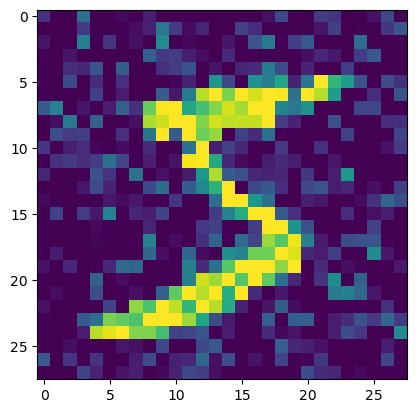

In [44]:
img = training_data.data[0] / 255.0

import matplotlib.pyplot as plt

plt.imshow(torch.clip(torch.randn_like(img) * 0.2 + img, 0, 1), vmax=1, vmin=0)
plt.show()

In [92]:
pl_model = My_VGG()
optimizer = torch.optim.Adam(pl_model.parameters())

device = get_cuda_device_or_cpu()
print(device)

pl_model.train()
pl_model.to(device)

for epoch in range(30):
    tl = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = pl_model(torch.clip(torch.randn_like(x) * 0.2 + x, 0, 1))
        # pred = pl_model(x)
        loss = F.cross_entropy(pred, y)
        tl += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'{epoch}: {tl}')

cuda:0
0: 104.62865267880261
1: 25.837366722989827
2: 19.182257233420387
3: 14.632602237863466
4: 11.076639368737233
5: 10.895489550457569
6: 8.635332506688428
7: 8.149514276992704
8: 7.851233634104574
9: 5.732414390657141
10: 6.462355725401721
11: 6.311868539369243
12: 4.513944307051133
13: 5.8906125082030485
14: 4.299127567798678
15: 3.691040608453477
16: 3.8337445329516413
17: 4.608633079609717
18: 2.901221751504636
19: 3.4762002997059653
20: 3.5370781477695346
21: 3.1549966842082995
22: 3.7545304114114515
23: 3.333956038572751
24: 1.9354383028237976
25: 2.8841094618126135
26: 3.2280427762605086
27: 3.138129673038293
28: 2.5586929008306925
29: 2.1621112660742483


In [93]:
pl_model_n = My_VGG()
optimizer = torch.optim.Adam(pl_model_n.parameters())

device = get_cuda_device_or_cpu()
print(device)

pl_model_n.train()
pl_model_n.to(device)

for epoch in range(30):
    tl = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = pl_model_n(x)
        loss = F.cross_entropy(pred, y)
        tl += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'{epoch}: {tl}')

cuda:0
0: 95.45457584271207
1: 23.501242176862434
2: 17.317514746508095
3: 12.708128690064768
4: 9.69794654276484
5: 7.694175520082354
6: 7.019853095534927
7: 6.76043456628031
8: 5.046693786244759
9: 4.611789718583168
10: 4.867115972421743
11: 4.169256209834202
12: 3.350057429454864
13: 3.746762307559038
14: 3.5913289150080345
15: 2.898325379684138
16: 2.420147037413585
17: 3.766933651531872
18: 2.18470442071407
19: 2.1555284492077362
20: 2.9633833090596227
21: 1.7798637789120448
22: 3.1870877132592454
23: 2.0632948796057633
24: 1.9076878594914888
25: 1.7166227608547615
26: 1.352544506437681
27: 2.5282507345404497
28: 3.0108213092529326
29: 0.7696719030224539


In [56]:
from myAE import Manager

manager = Manager()
manager.prepare_data()

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [130]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    pl_x = pl_model.get_perceptual_loss(x)
    pl_pred = pl_model.get_perceptual_loss(pred)
    ll = 0
    rate = 1.
    for px, pp in zip(pl_x, pl_pred):
        ll += rate * F.mse_loss(pp, px, reduction='sum') / len(x)
        rate /= 16
    # ll += F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager.set_default_model(4, 2)
device = get_cuda_device_or_cpu()
pl_model.to(device)
hist = manager.train(calc_loss, epochs=30)
manager.add_model('pl rate 16 30')

Now, it is working on cuda:0.


100%|██████████| 30/30 [06:38<00:00, 13.30s/it]


In [58]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager.set_default_model(4, 2)
device = get_cuda_device_or_cpu()
pl_model.to(device)
hist = manager.train(calc_loss, epochs=30)
manager.add_model('vanilla 30')

Now, it is working on cuda:0.


100%|██████████| 30/30 [03:48<00:00,  7.63s/it]


In [59]:
def compare_with_vanilla(manager, name, original_name='vanilla 30'):
    fig, (axs1, axs2, axs3) = plt.subplots(nrows=3, ncols=5, figsize=[20, 13])

    manager.swap_current_model(original_name)
    manager.model.to('cpu')
    manager.model.eval()

    for x, y in manager.train_dataloader:
        with torch.no_grad():
            h = manager.model.get_submodule("encoder")(x)
            mu = h[:, :2]
            x_hats = manager.model.get_submodule("decoder")(mu)
        for ax, img in zip(axs1, x[:5]):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        for ax, img in zip(axs2, x_hats):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')

        
        with torch.no_grad():
            manager.swap_current_model(name)

            manager.model.to('cpu')
            manager.model.eval()

            h = manager.model.get_submodule("encoder")(x)
            mu = h[:, :2]
            x_hats = manager.model.get_submodule("decoder")(mu)
        for ax, img in zip(axs3, x_hats):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        
        break
    plt.tight_layout()

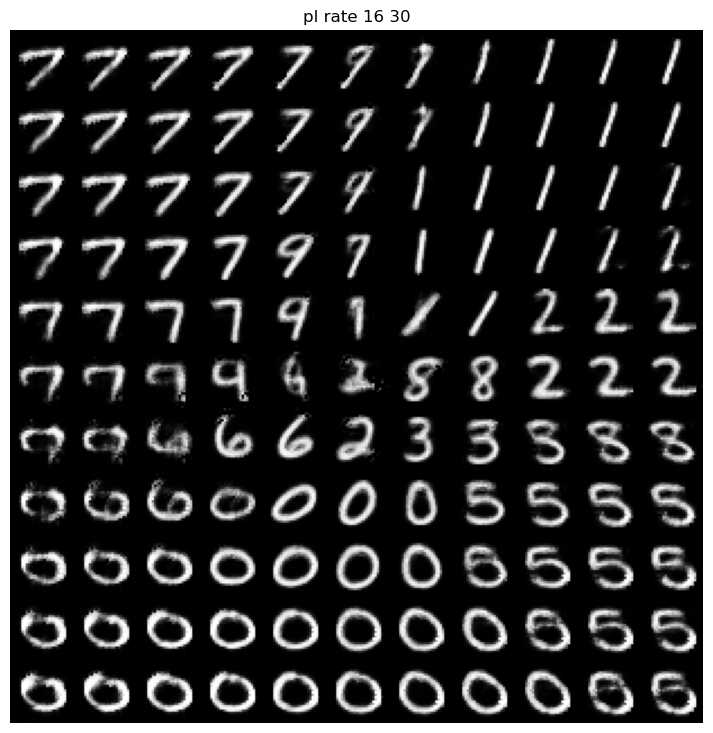

In [137]:
manager.plot_generated_images('pl rate 16 30')

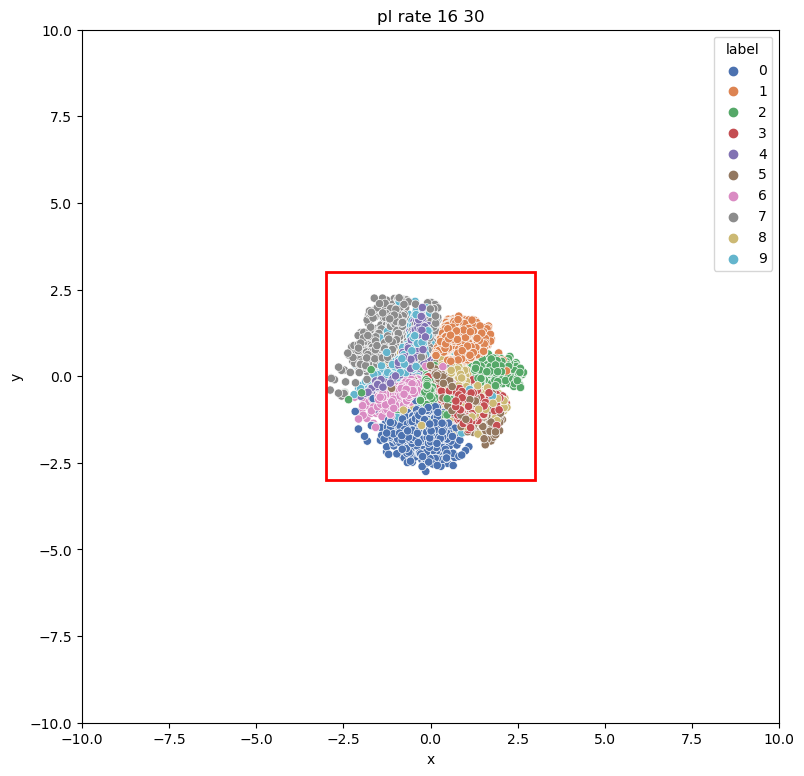

In [136]:
def encode(model, x, y):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    return [mu]

manager.show_latent_space('pl rate 16 30', encode)

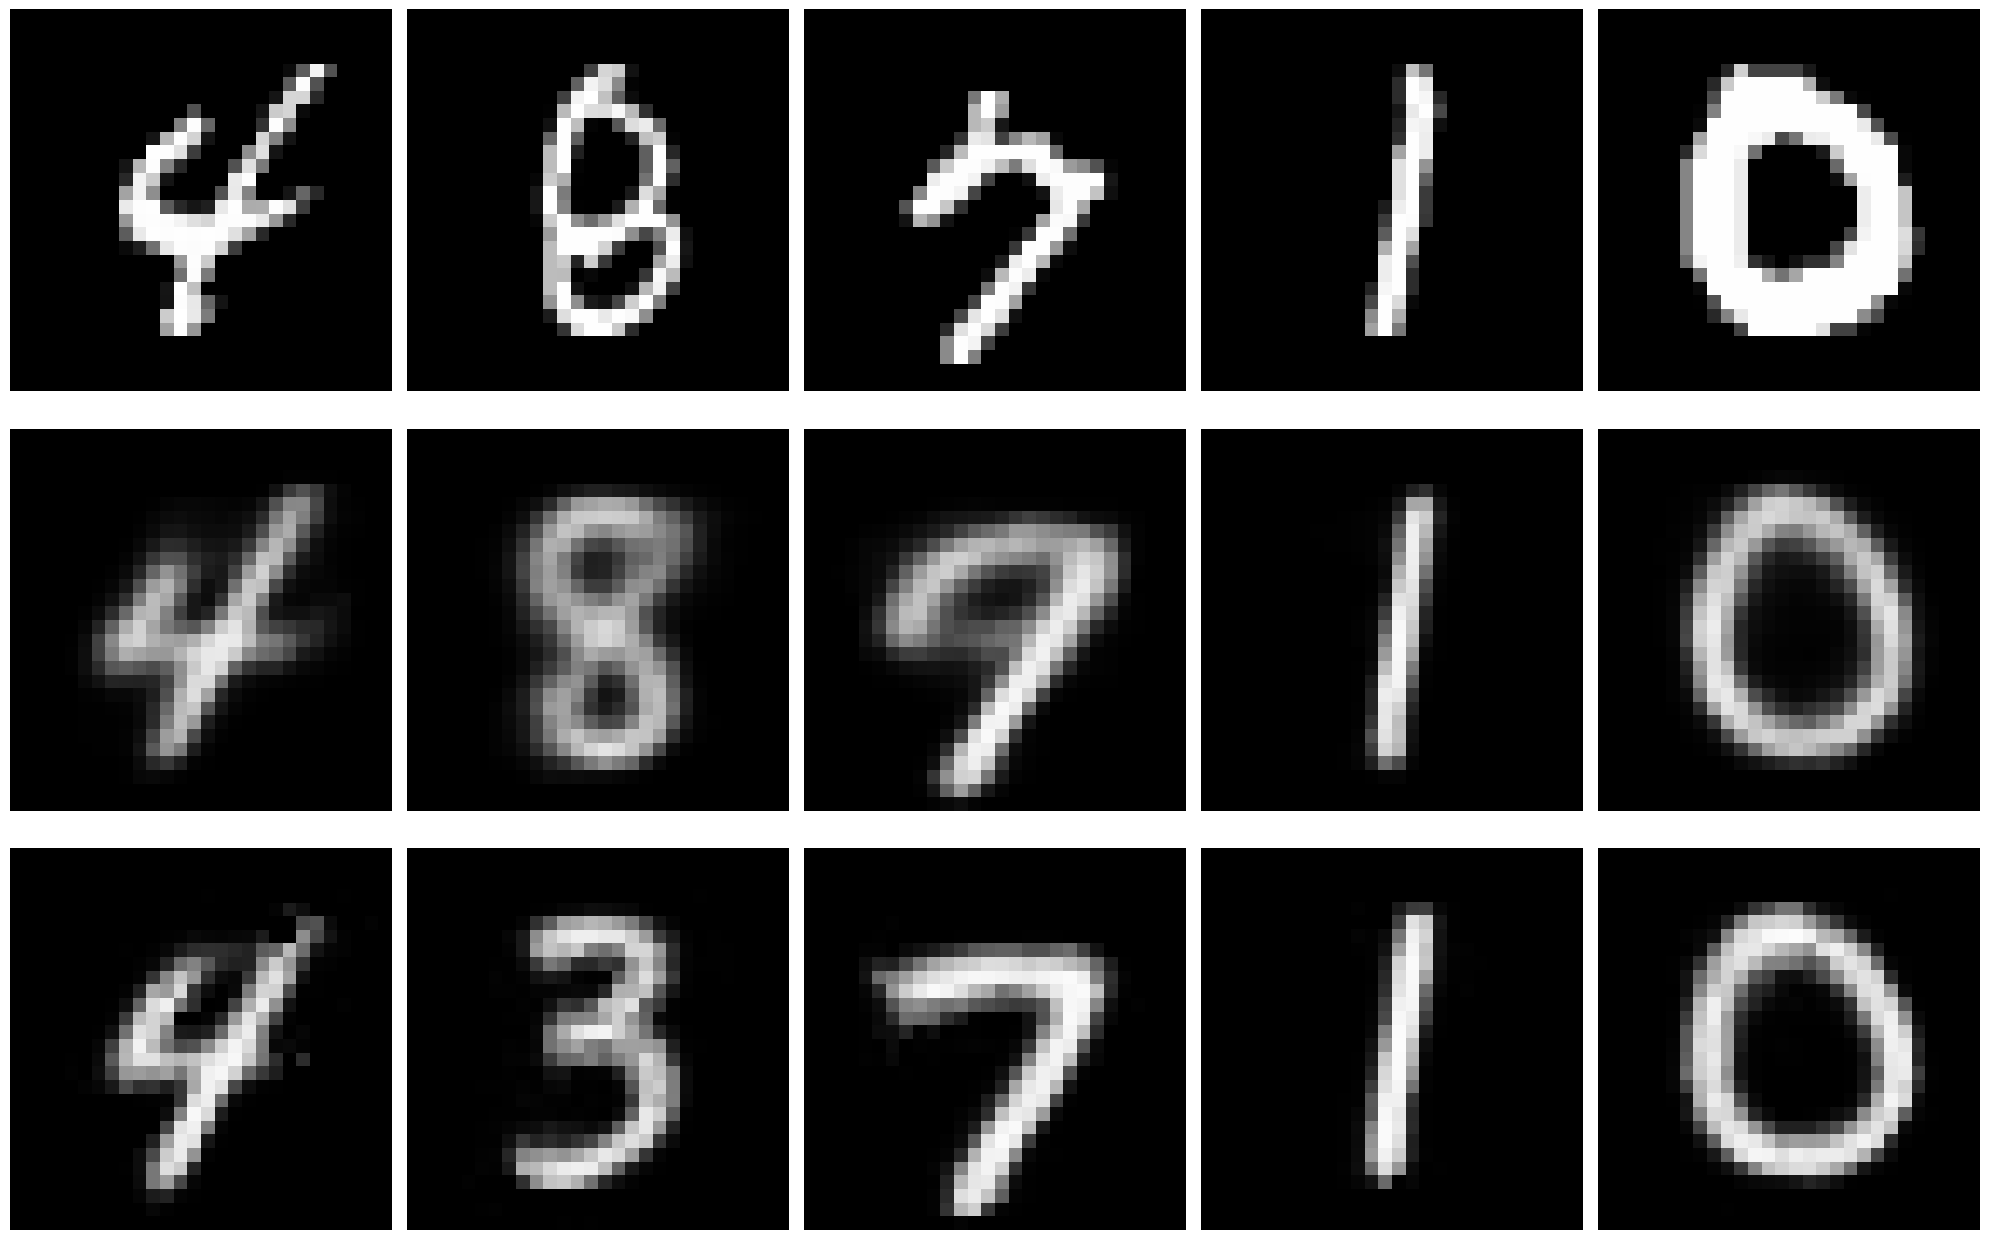

In [133]:
compare_with_vanilla(manager, 'pl rate 16 30')

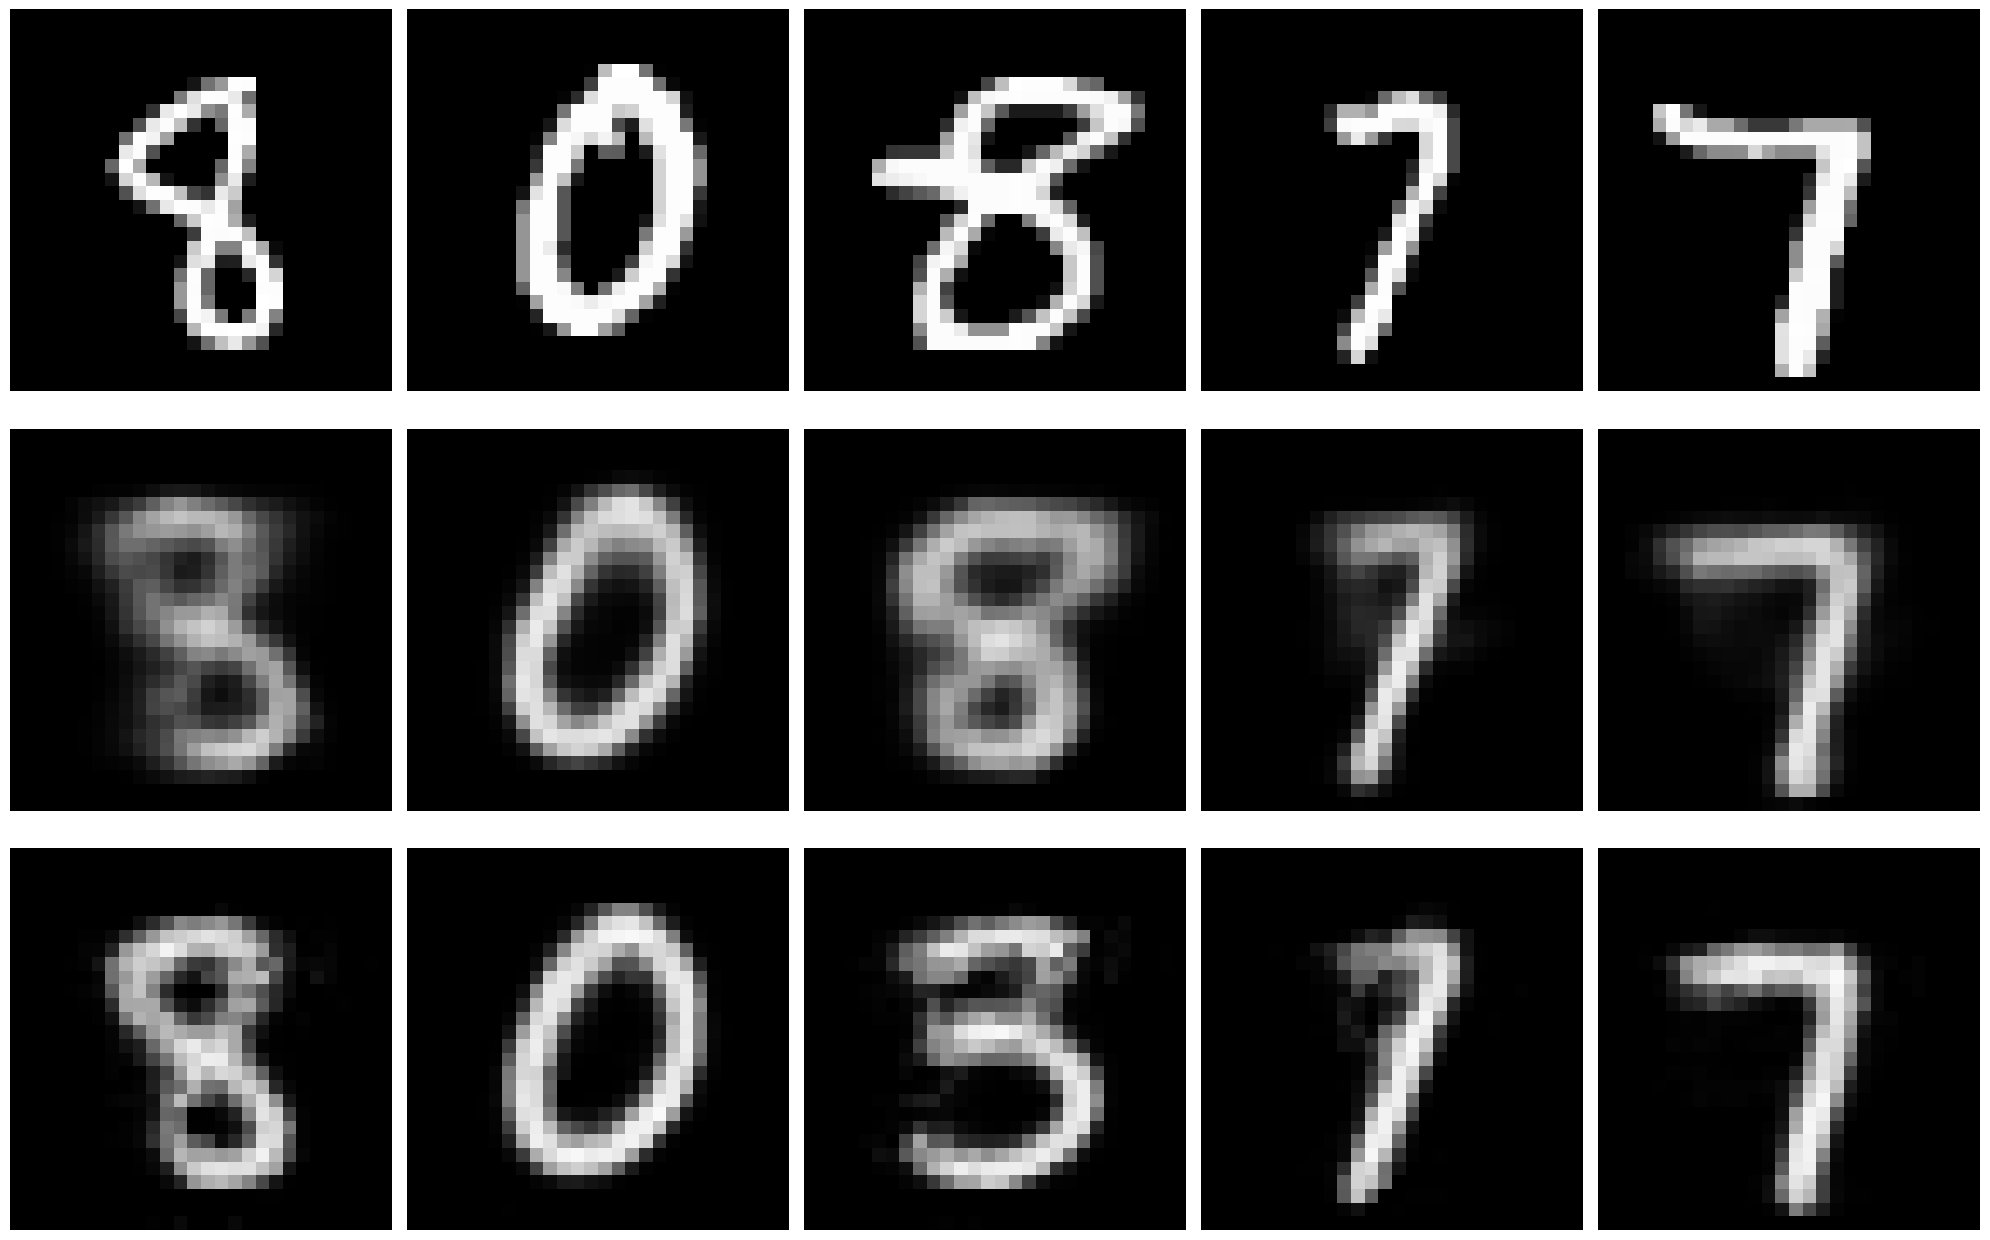

In [129]:
compare_with_vanilla(manager, 'pl rate 8 30')

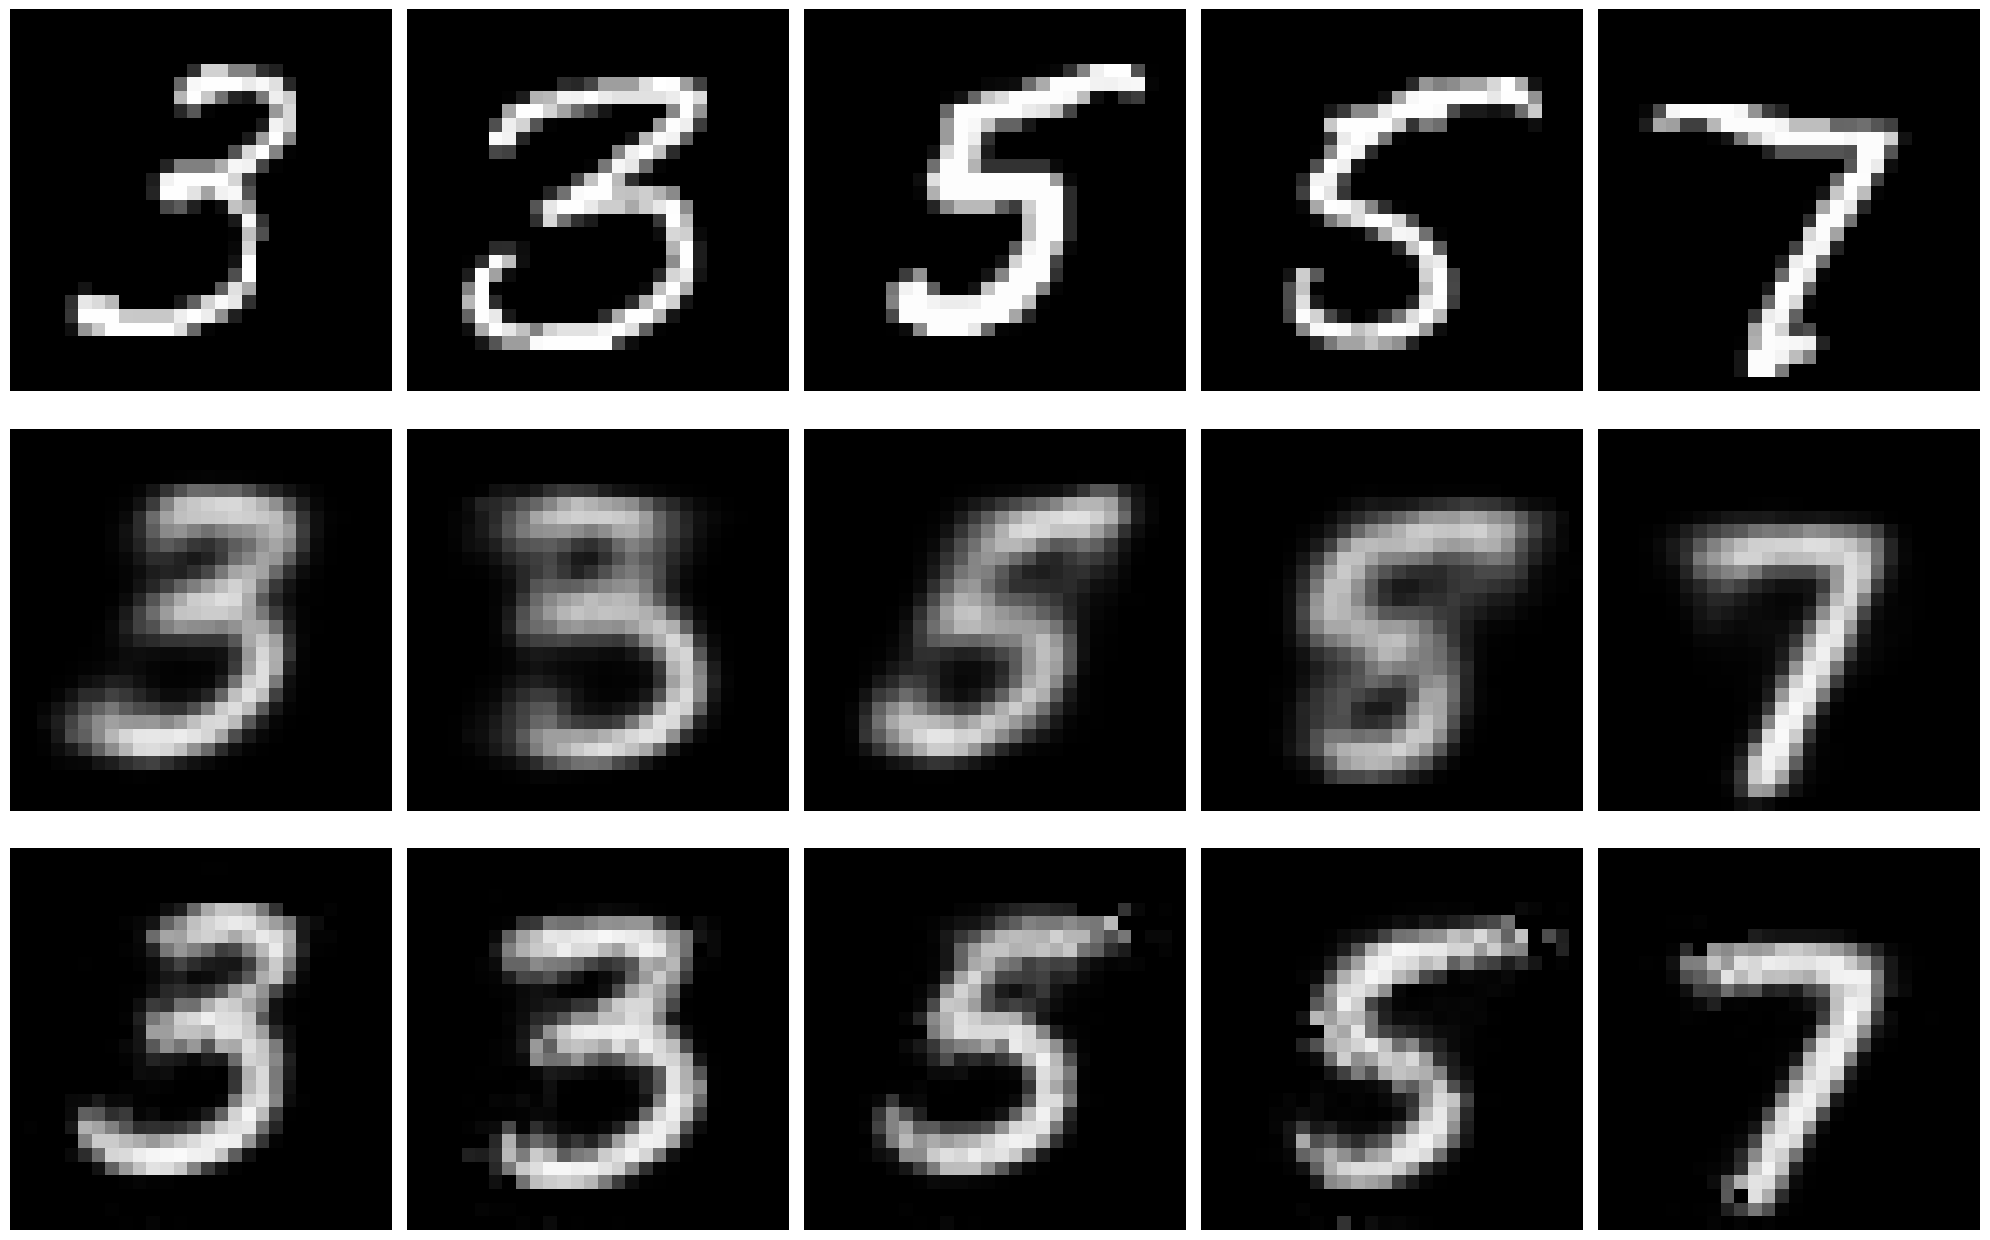

In [117]:
compare_with_vanilla(manager, 'pl rate 4 30')

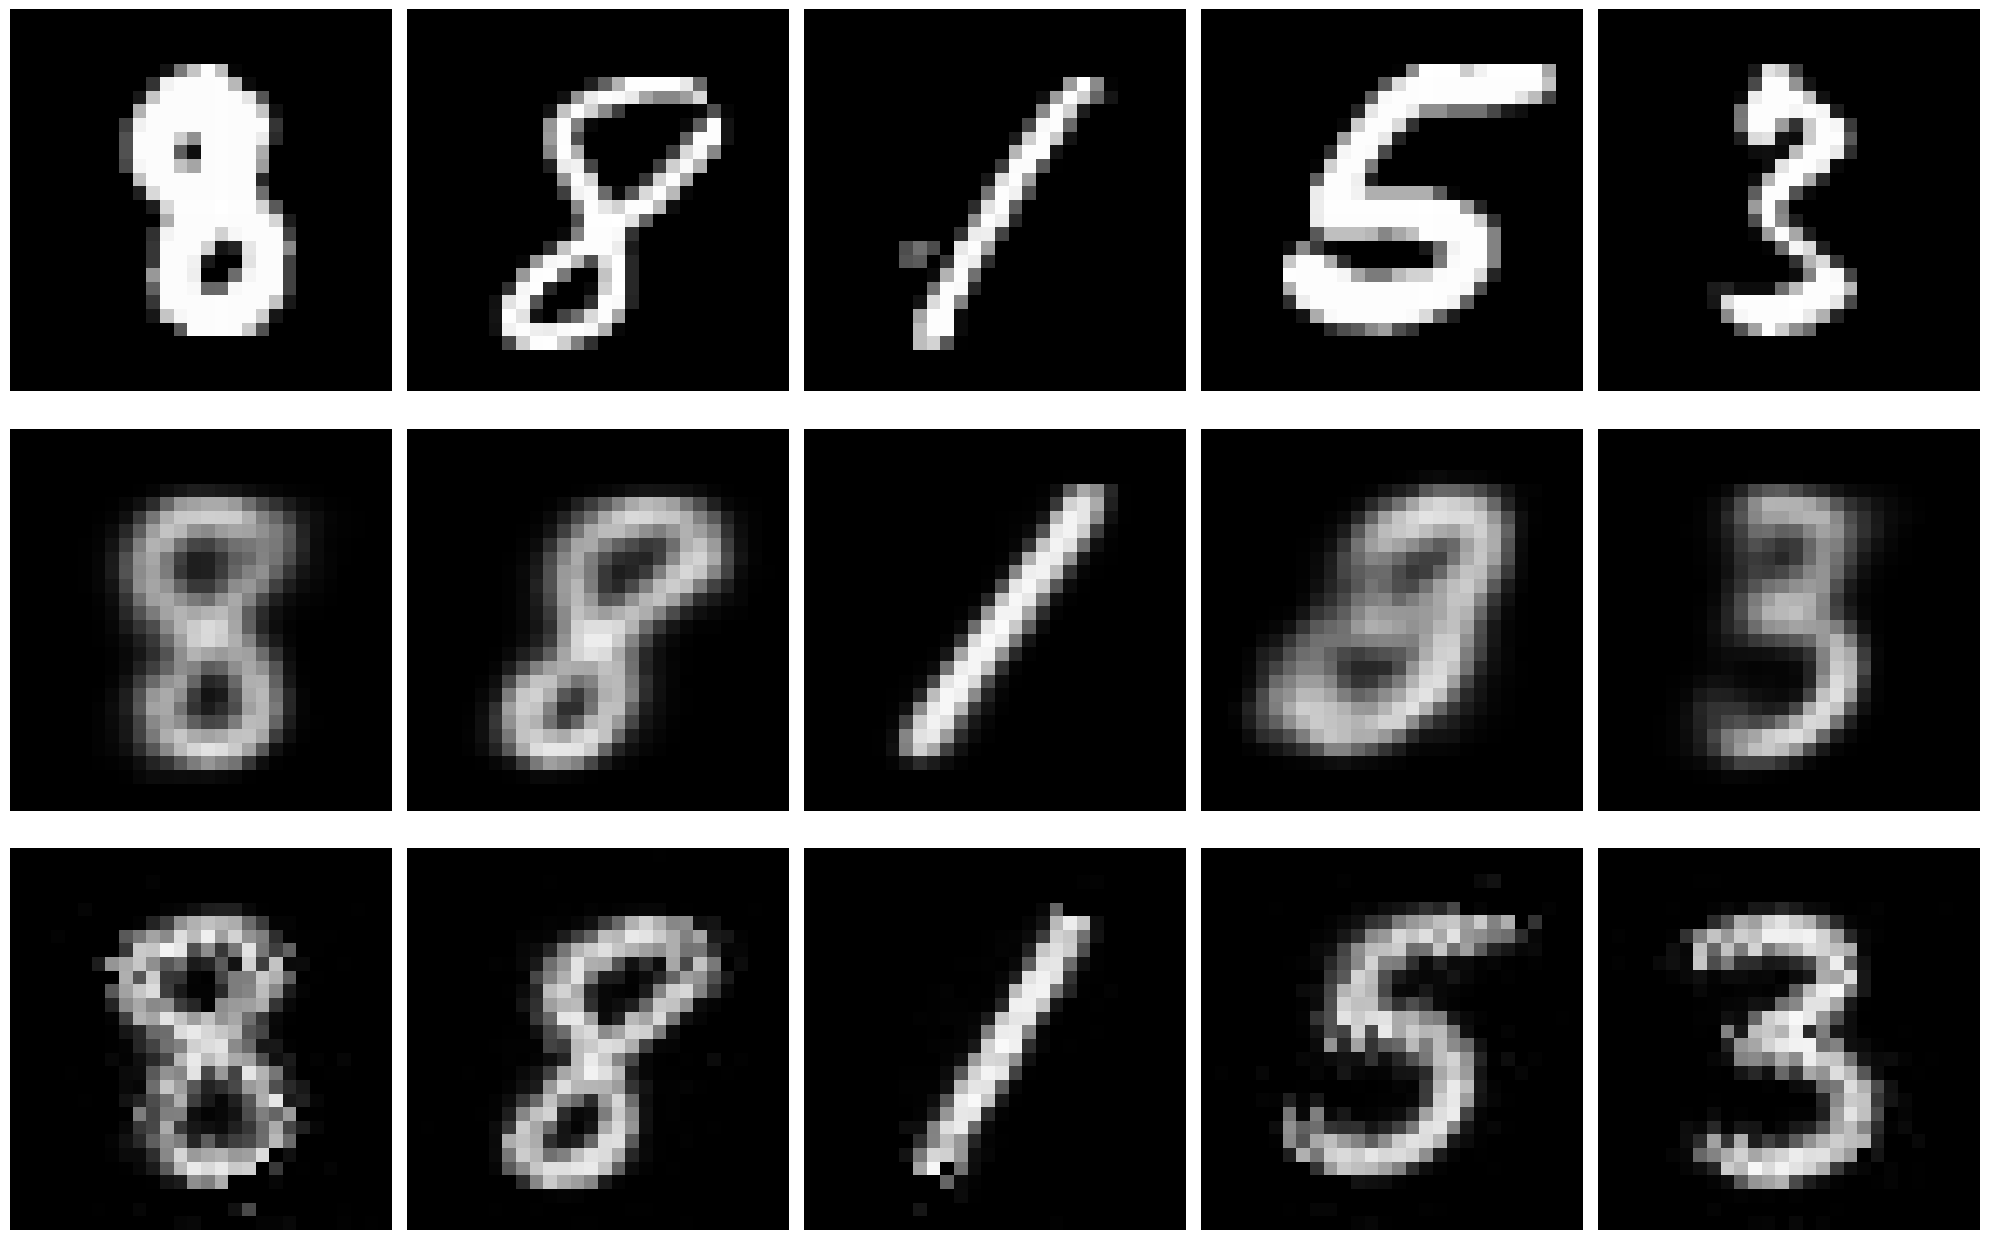

In [112]:
compare_with_vanilla(manager, 'pl rate 30')

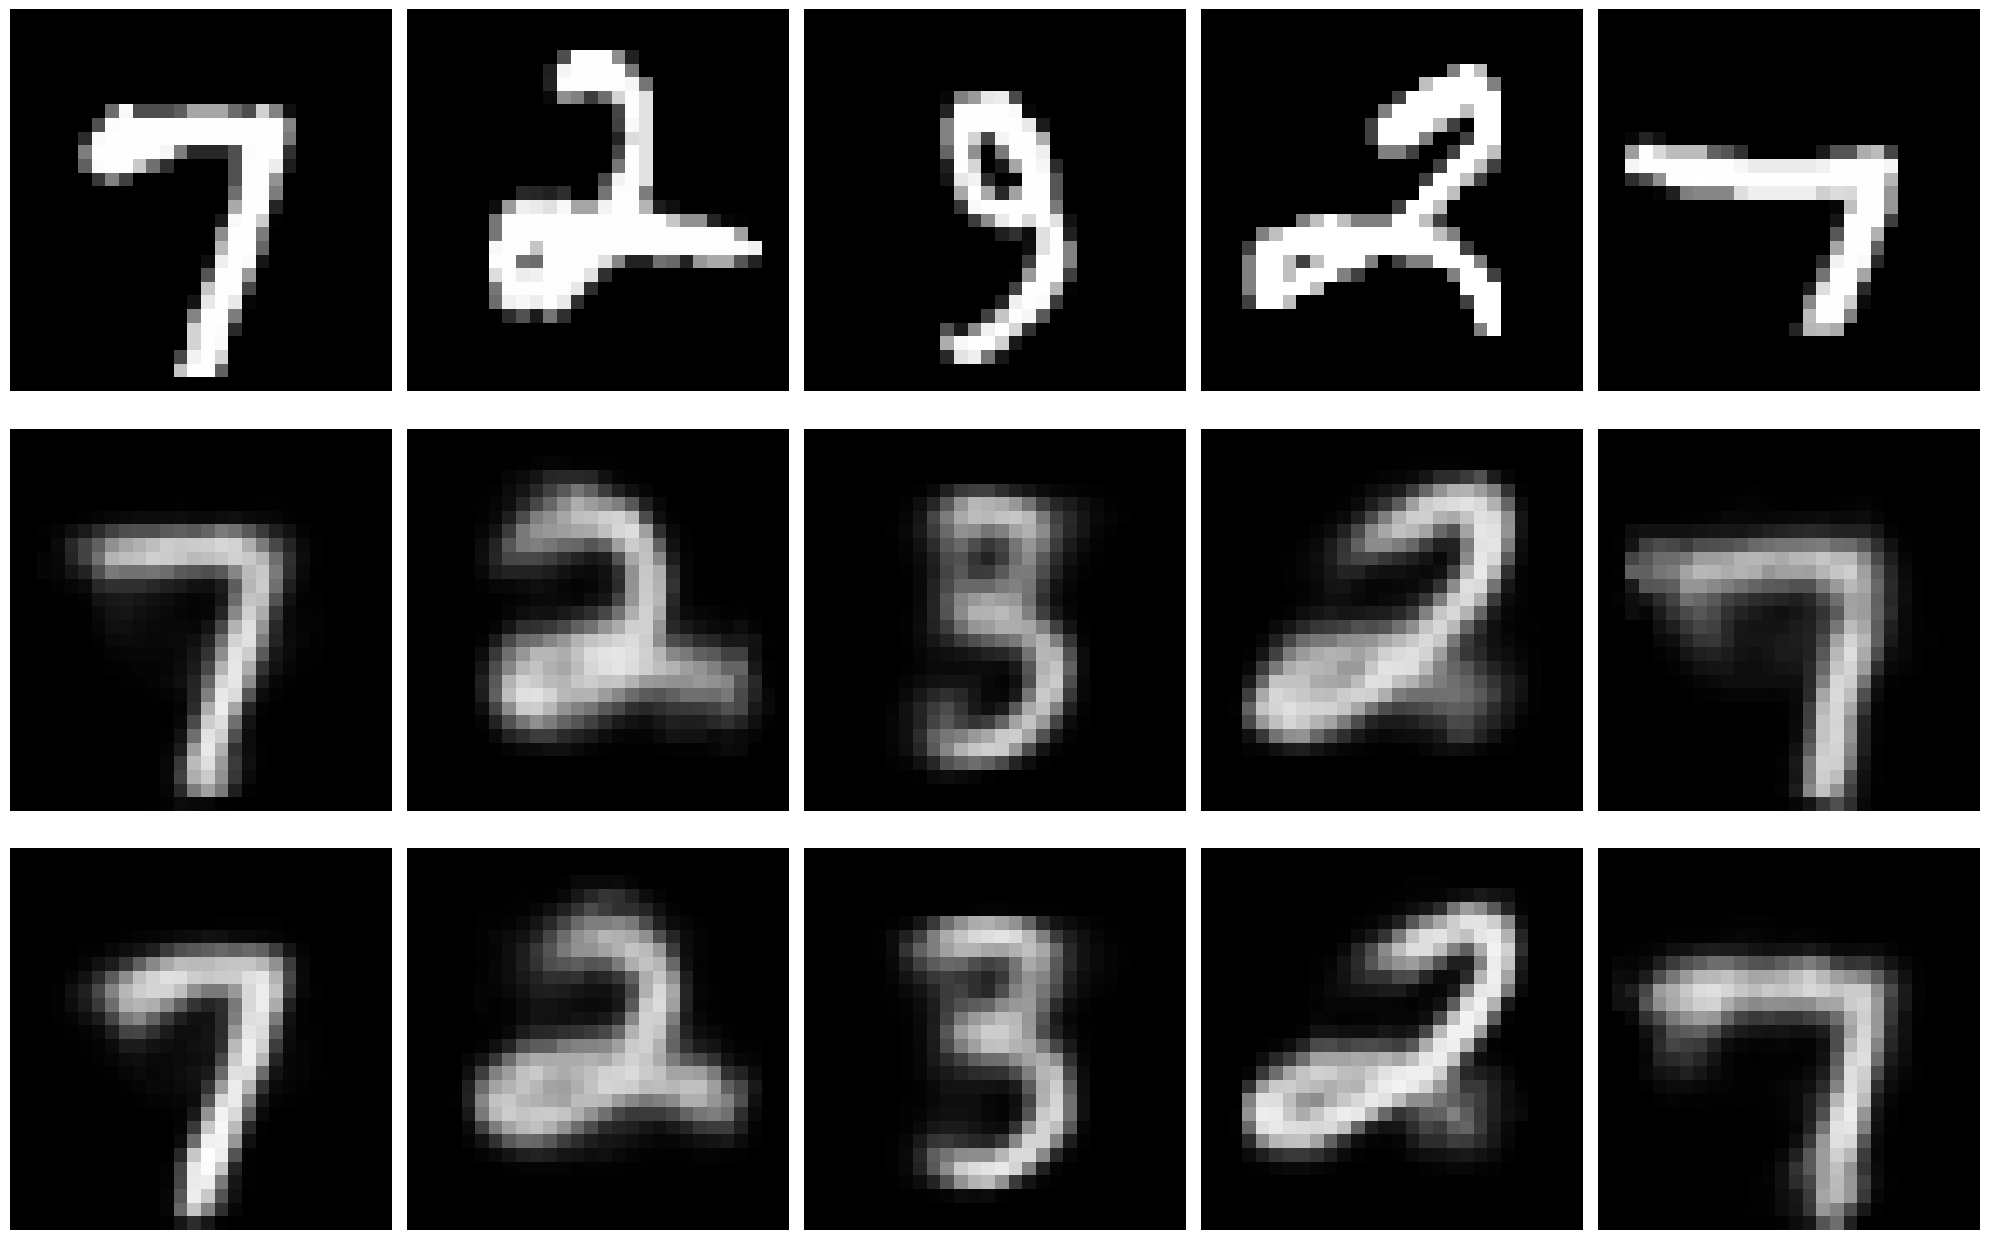

In [110]:
compare_with_vanilla(manager, 'pl +ce -6 30')

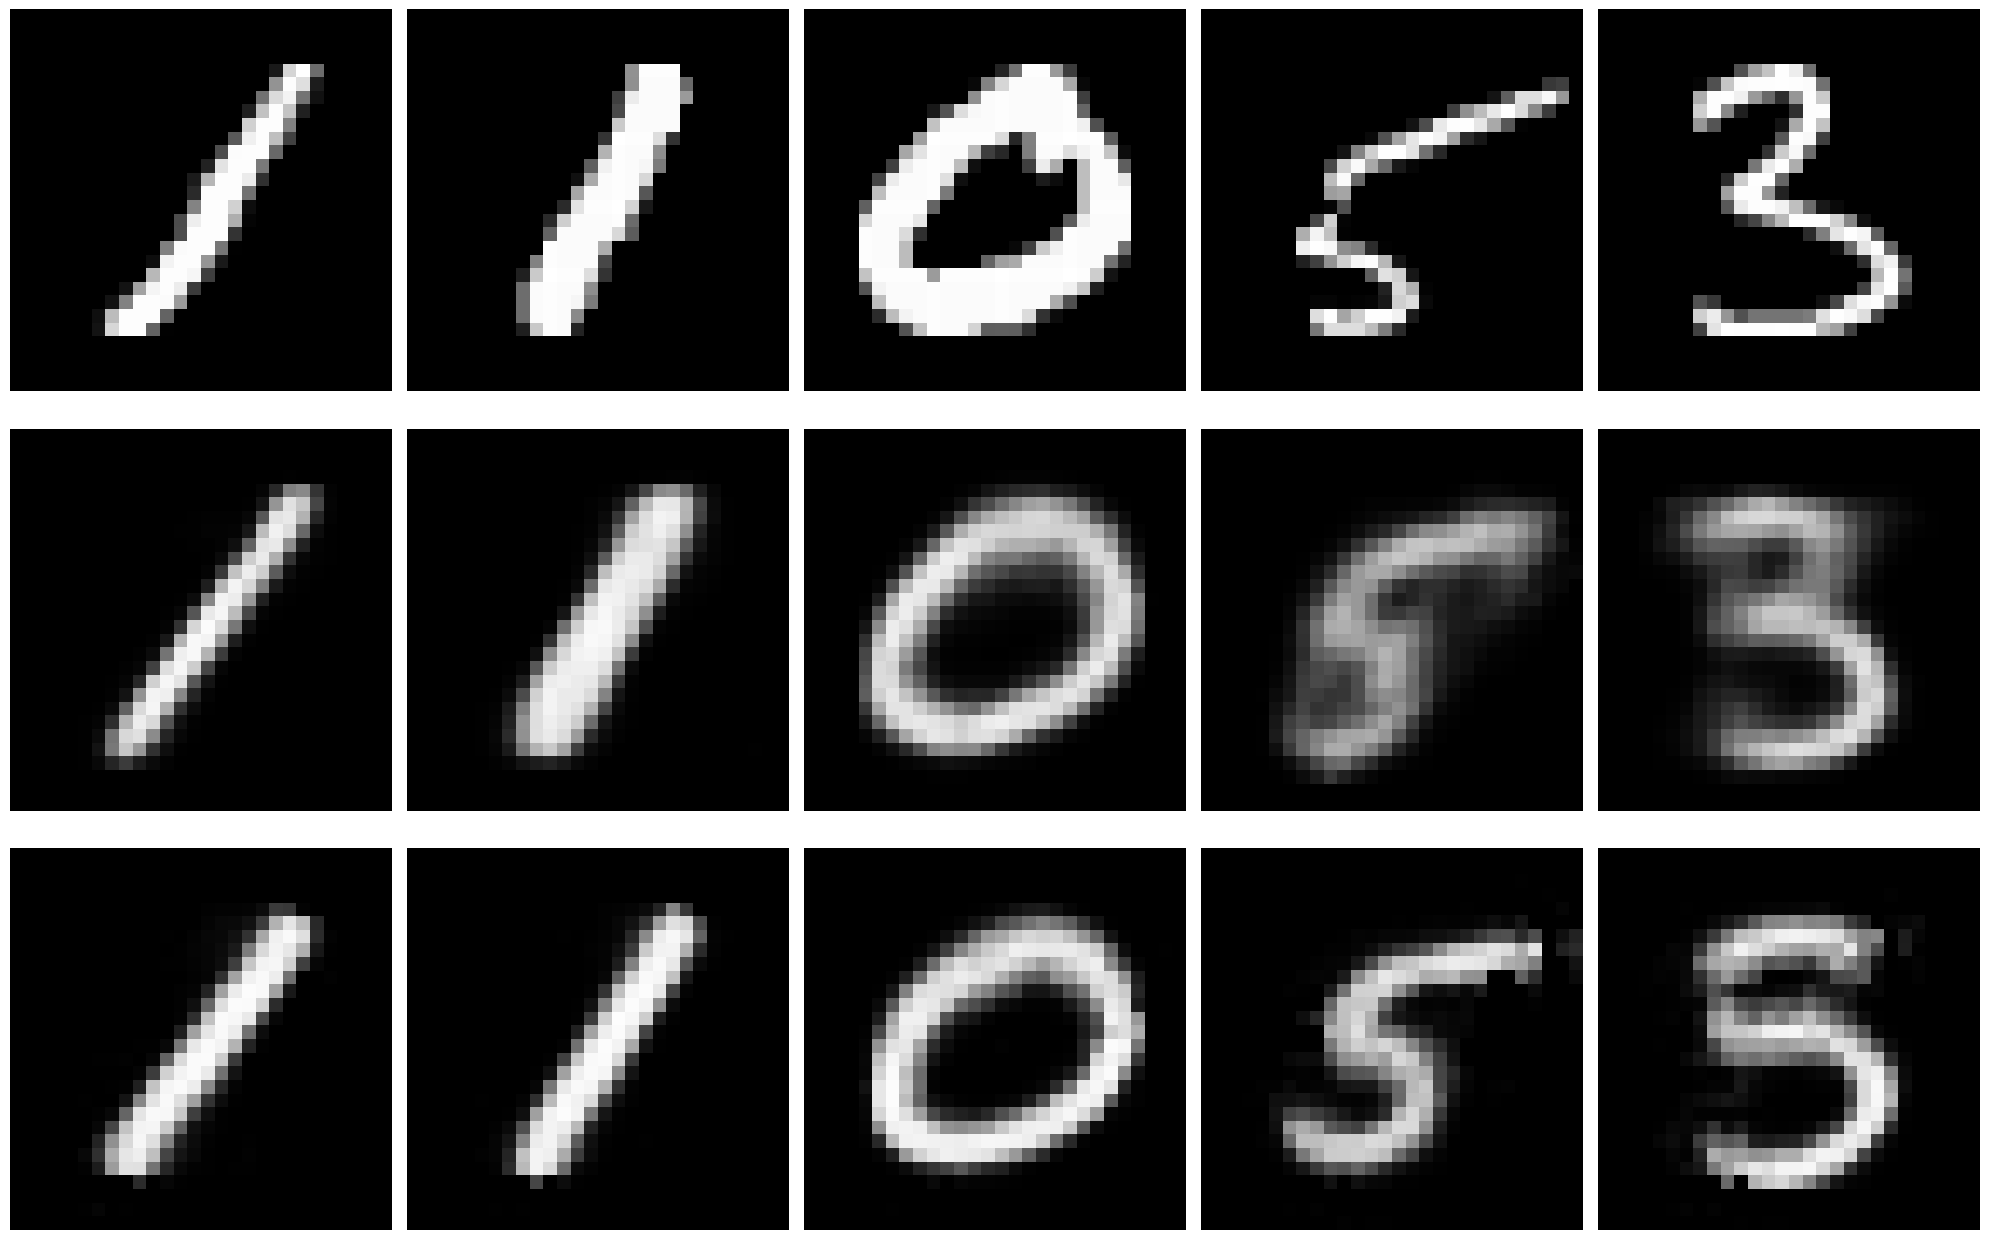

In [108]:
compare_with_vanilla(manager, 'pl -6 30')

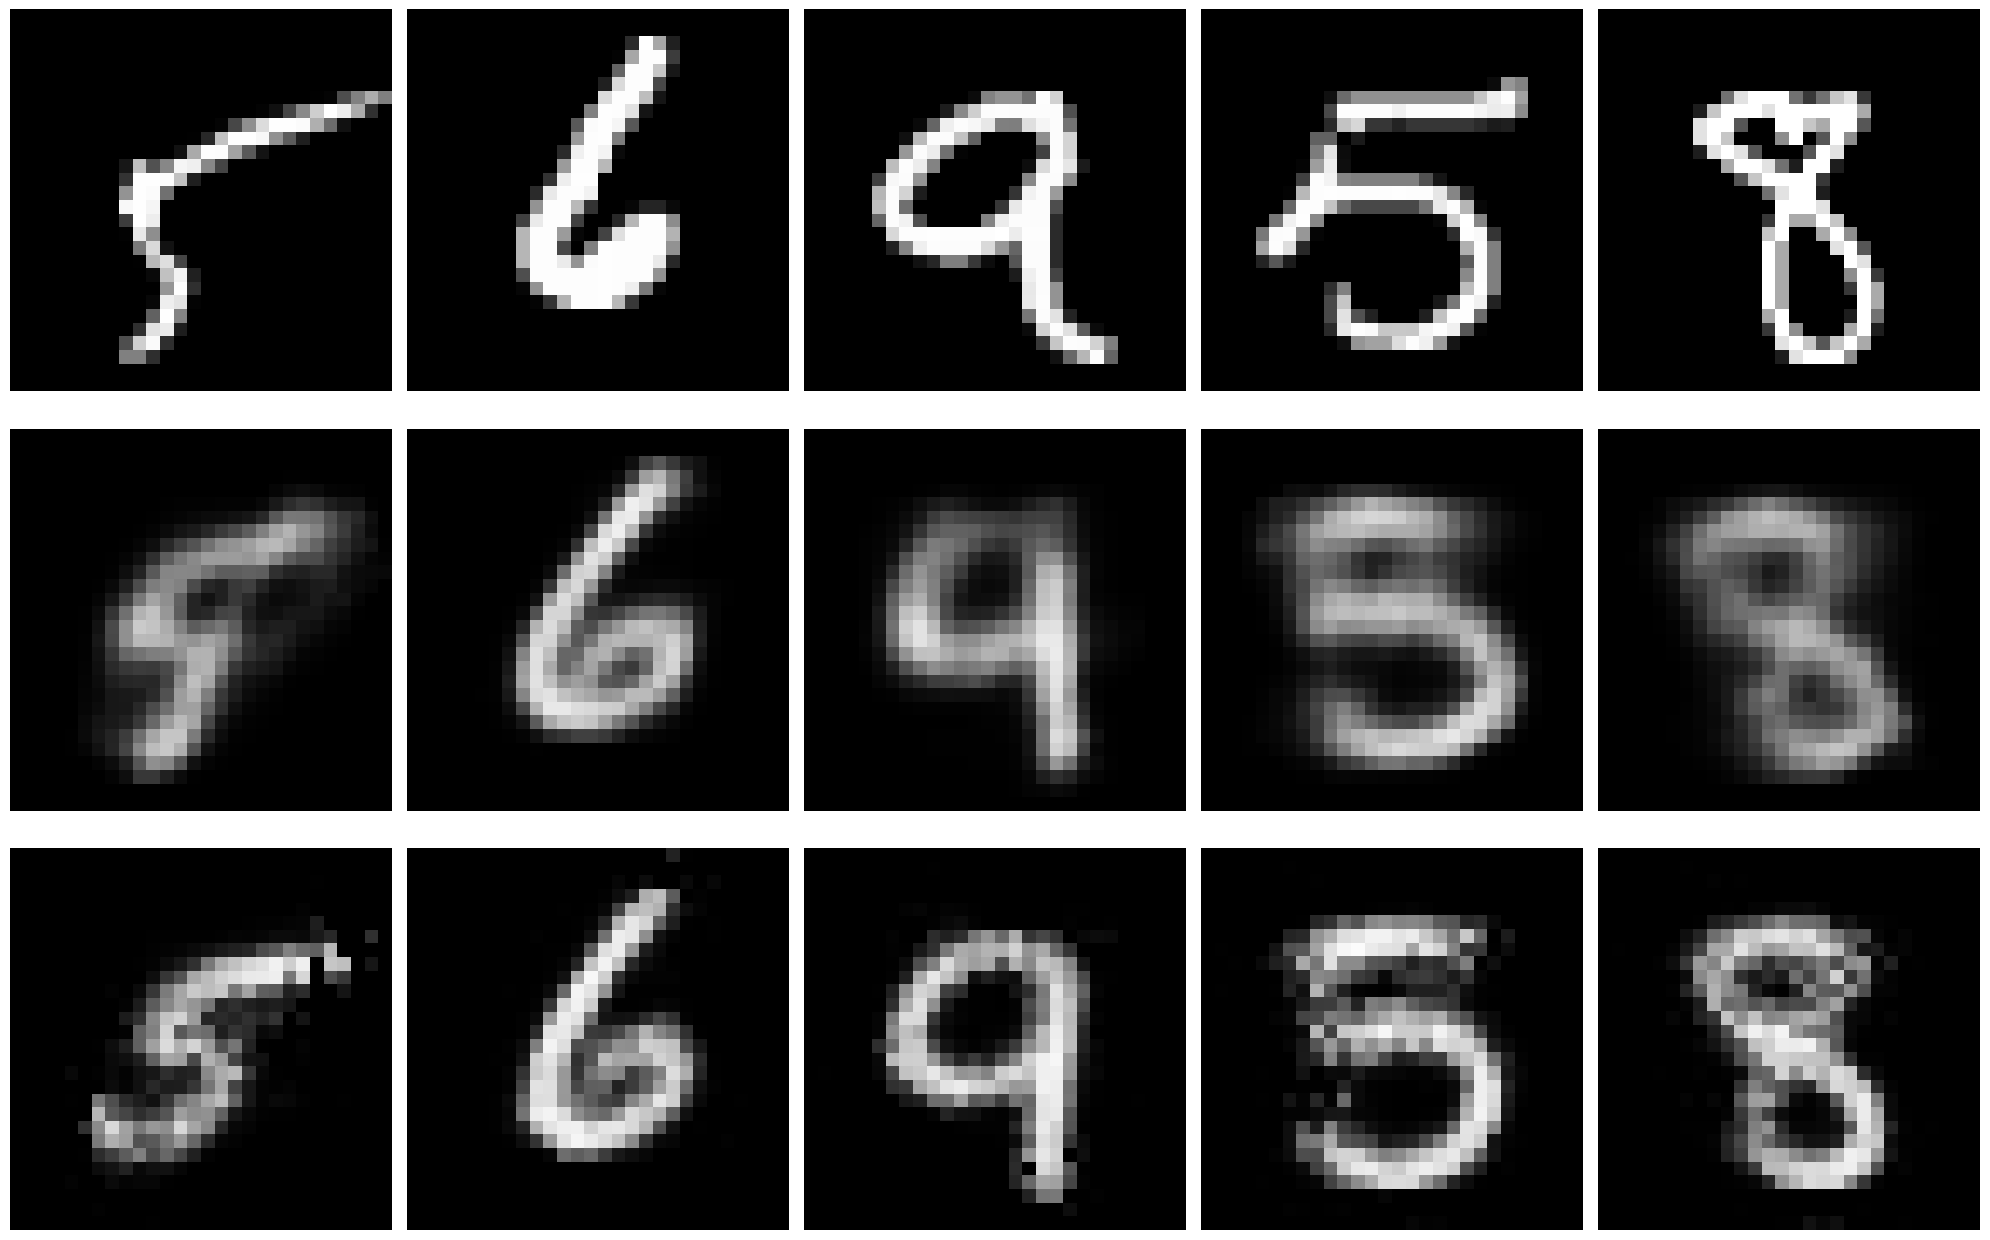

In [102]:
compare_with_vanilla(manager, 'pl -5 30')

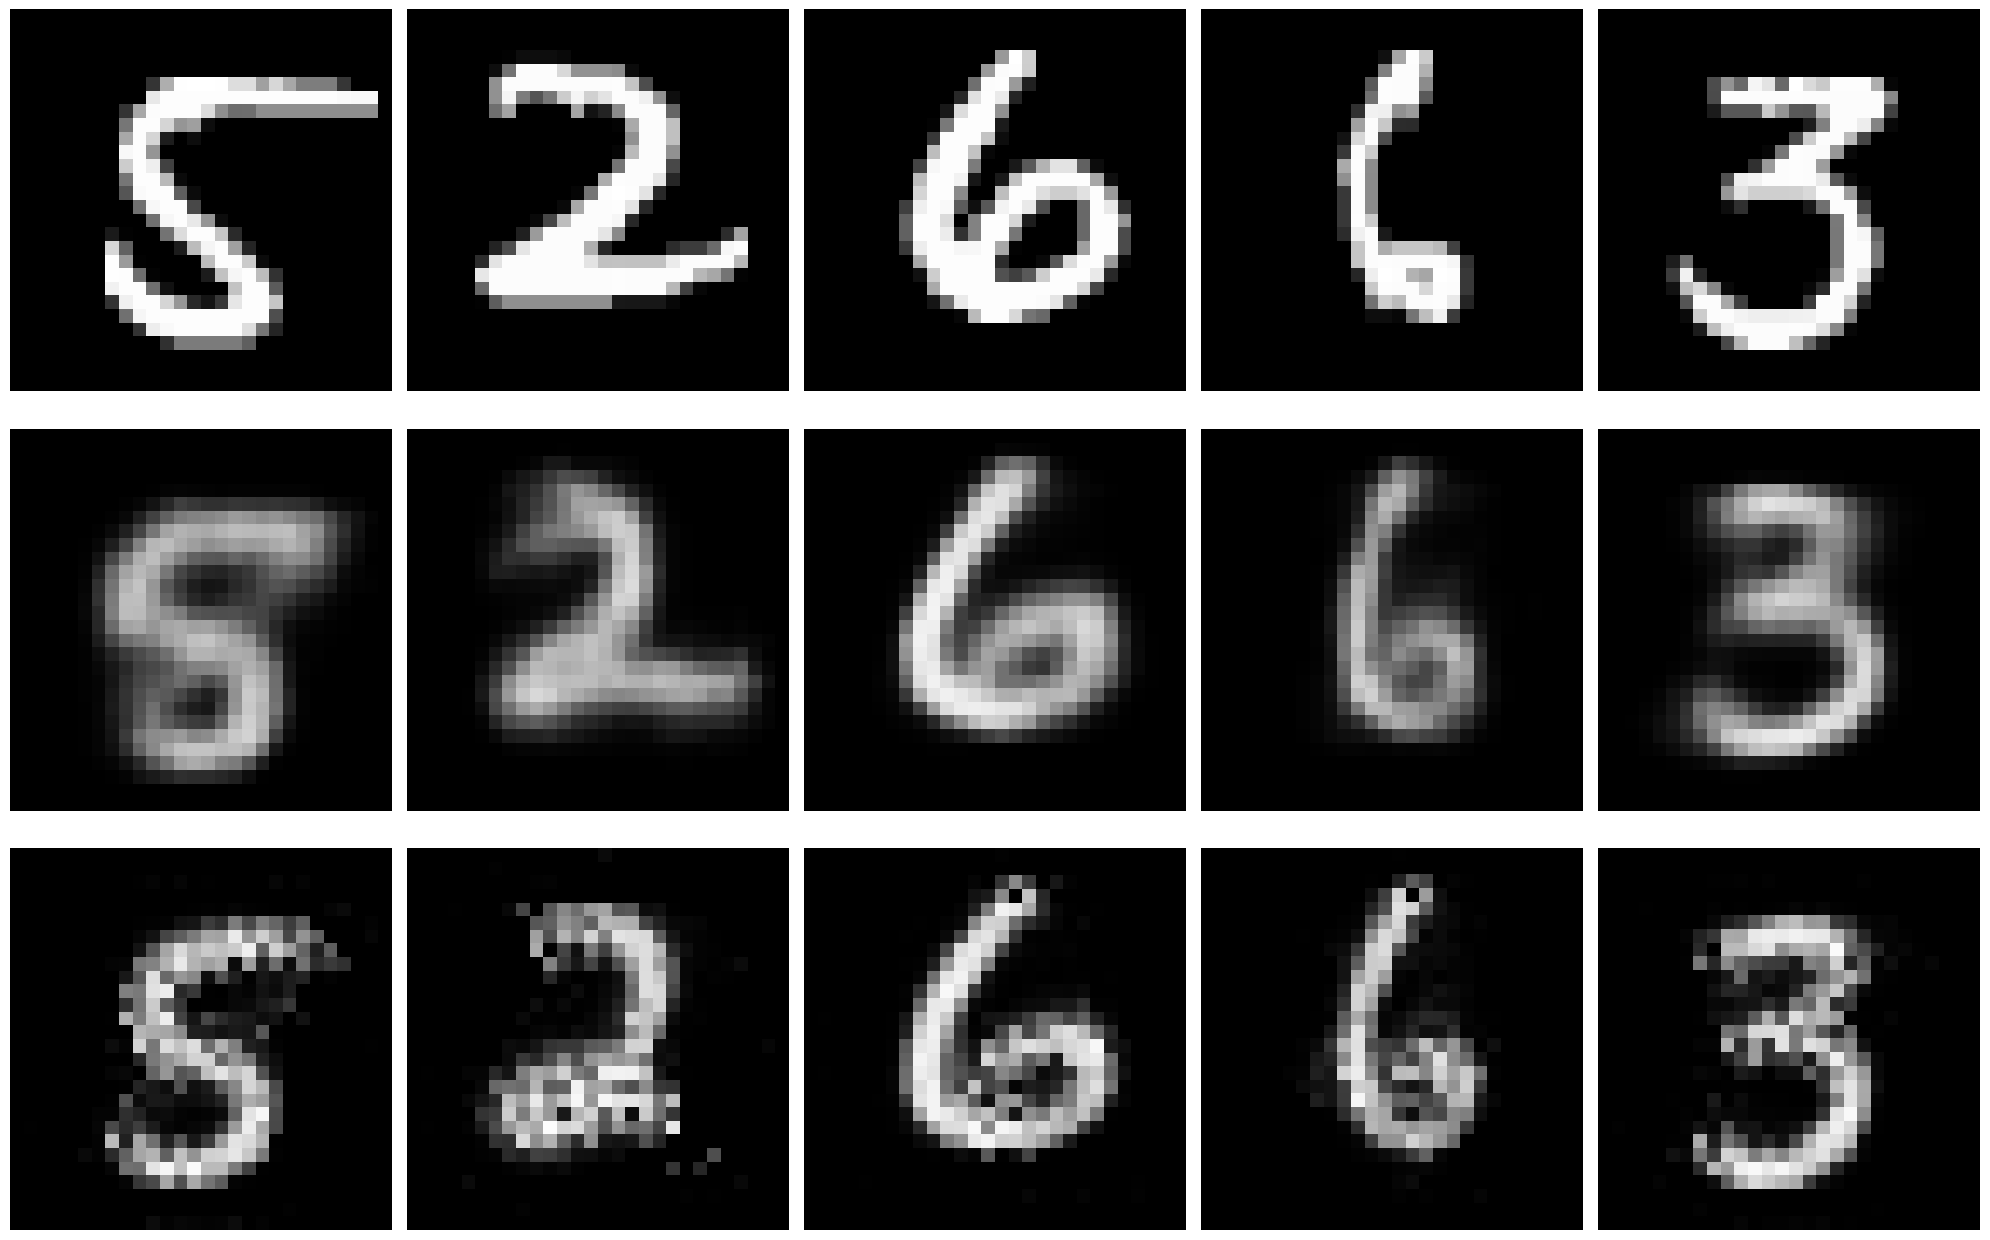

In [100]:
compare_with_vanilla(manager, 'pl -4 30')

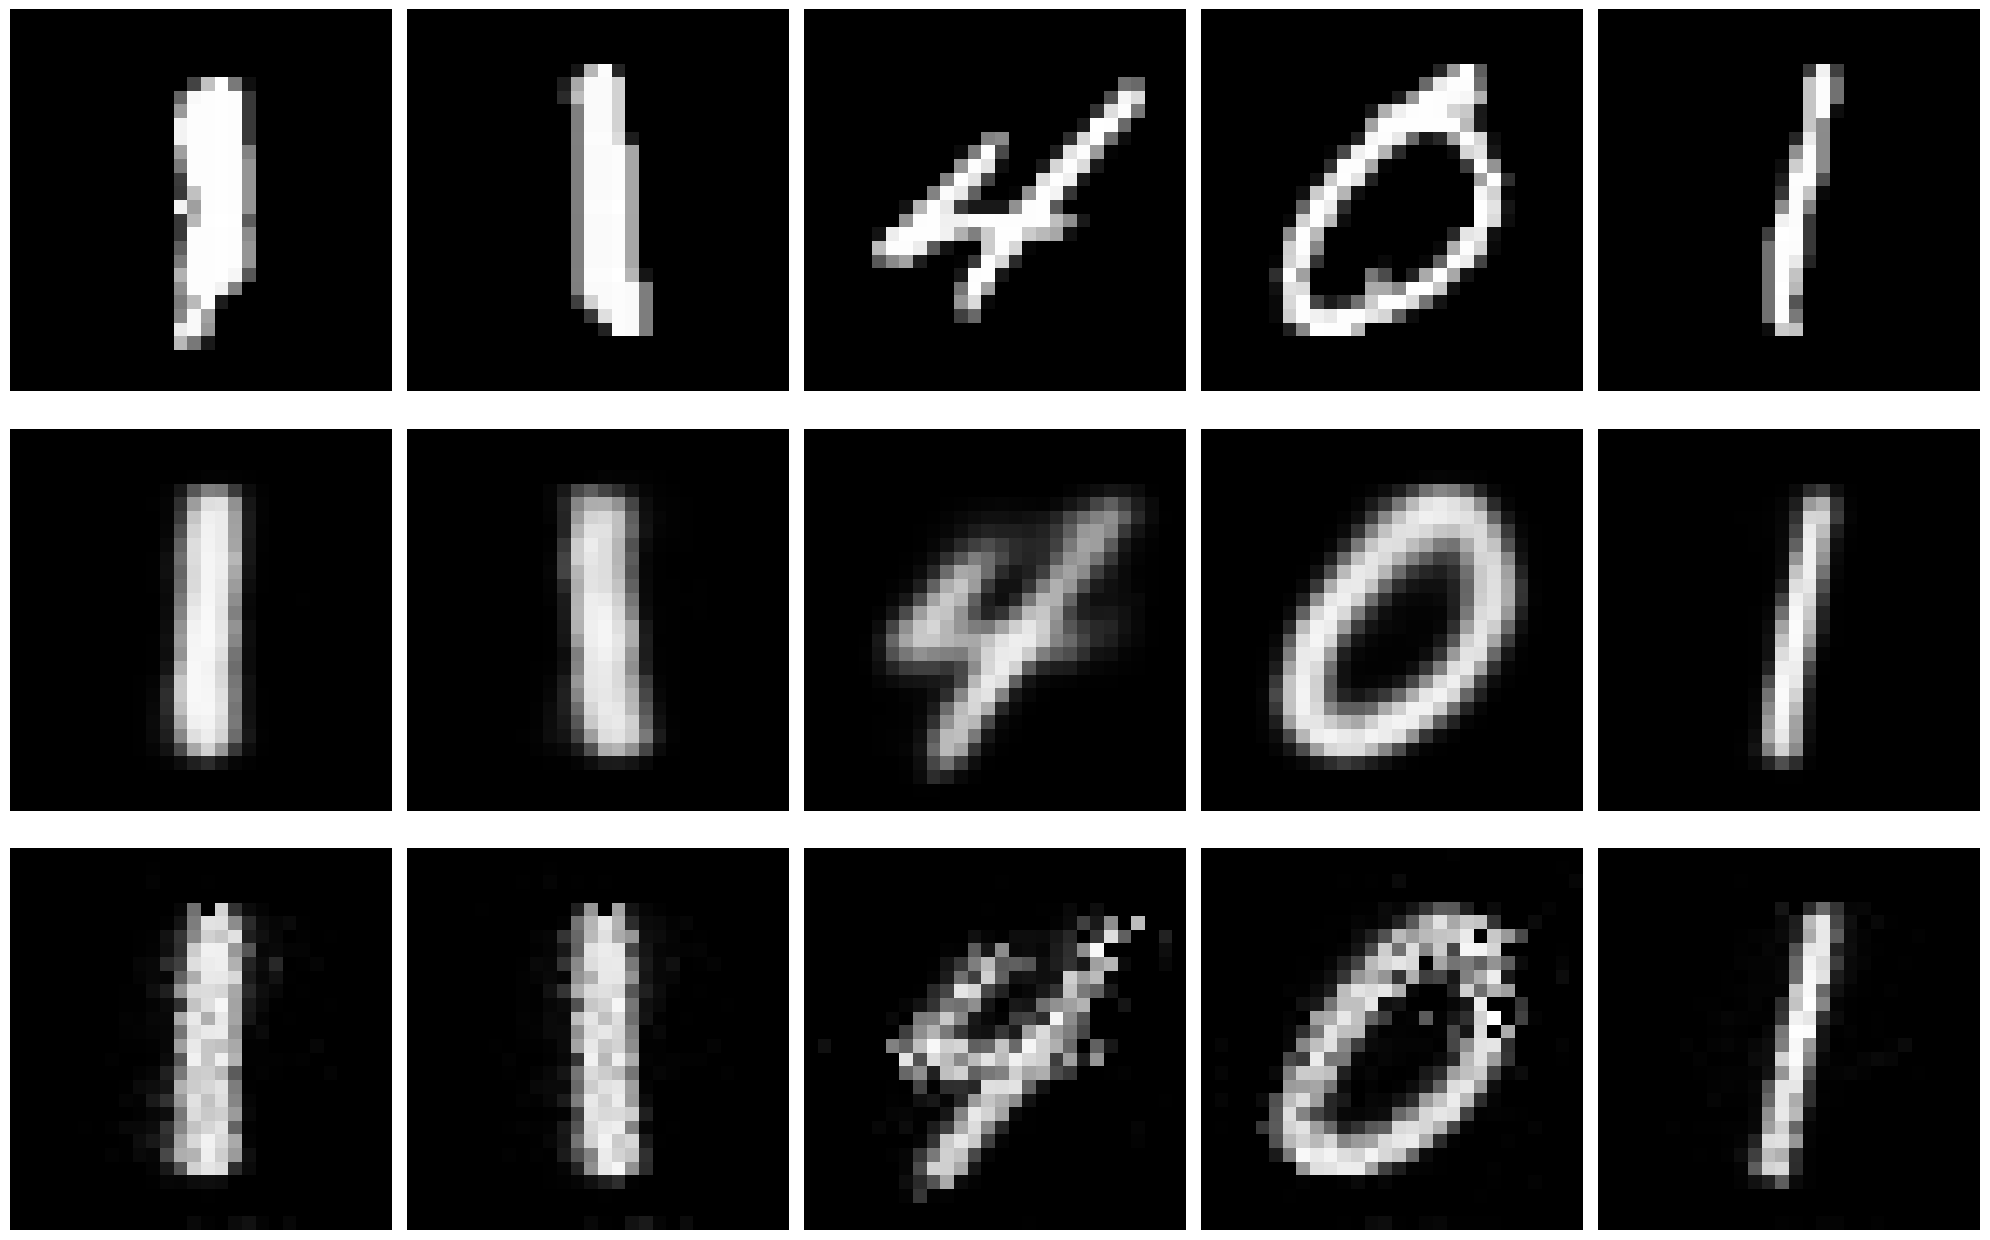

In [98]:
compare_with_vanilla(manager, 'pl -3 30')

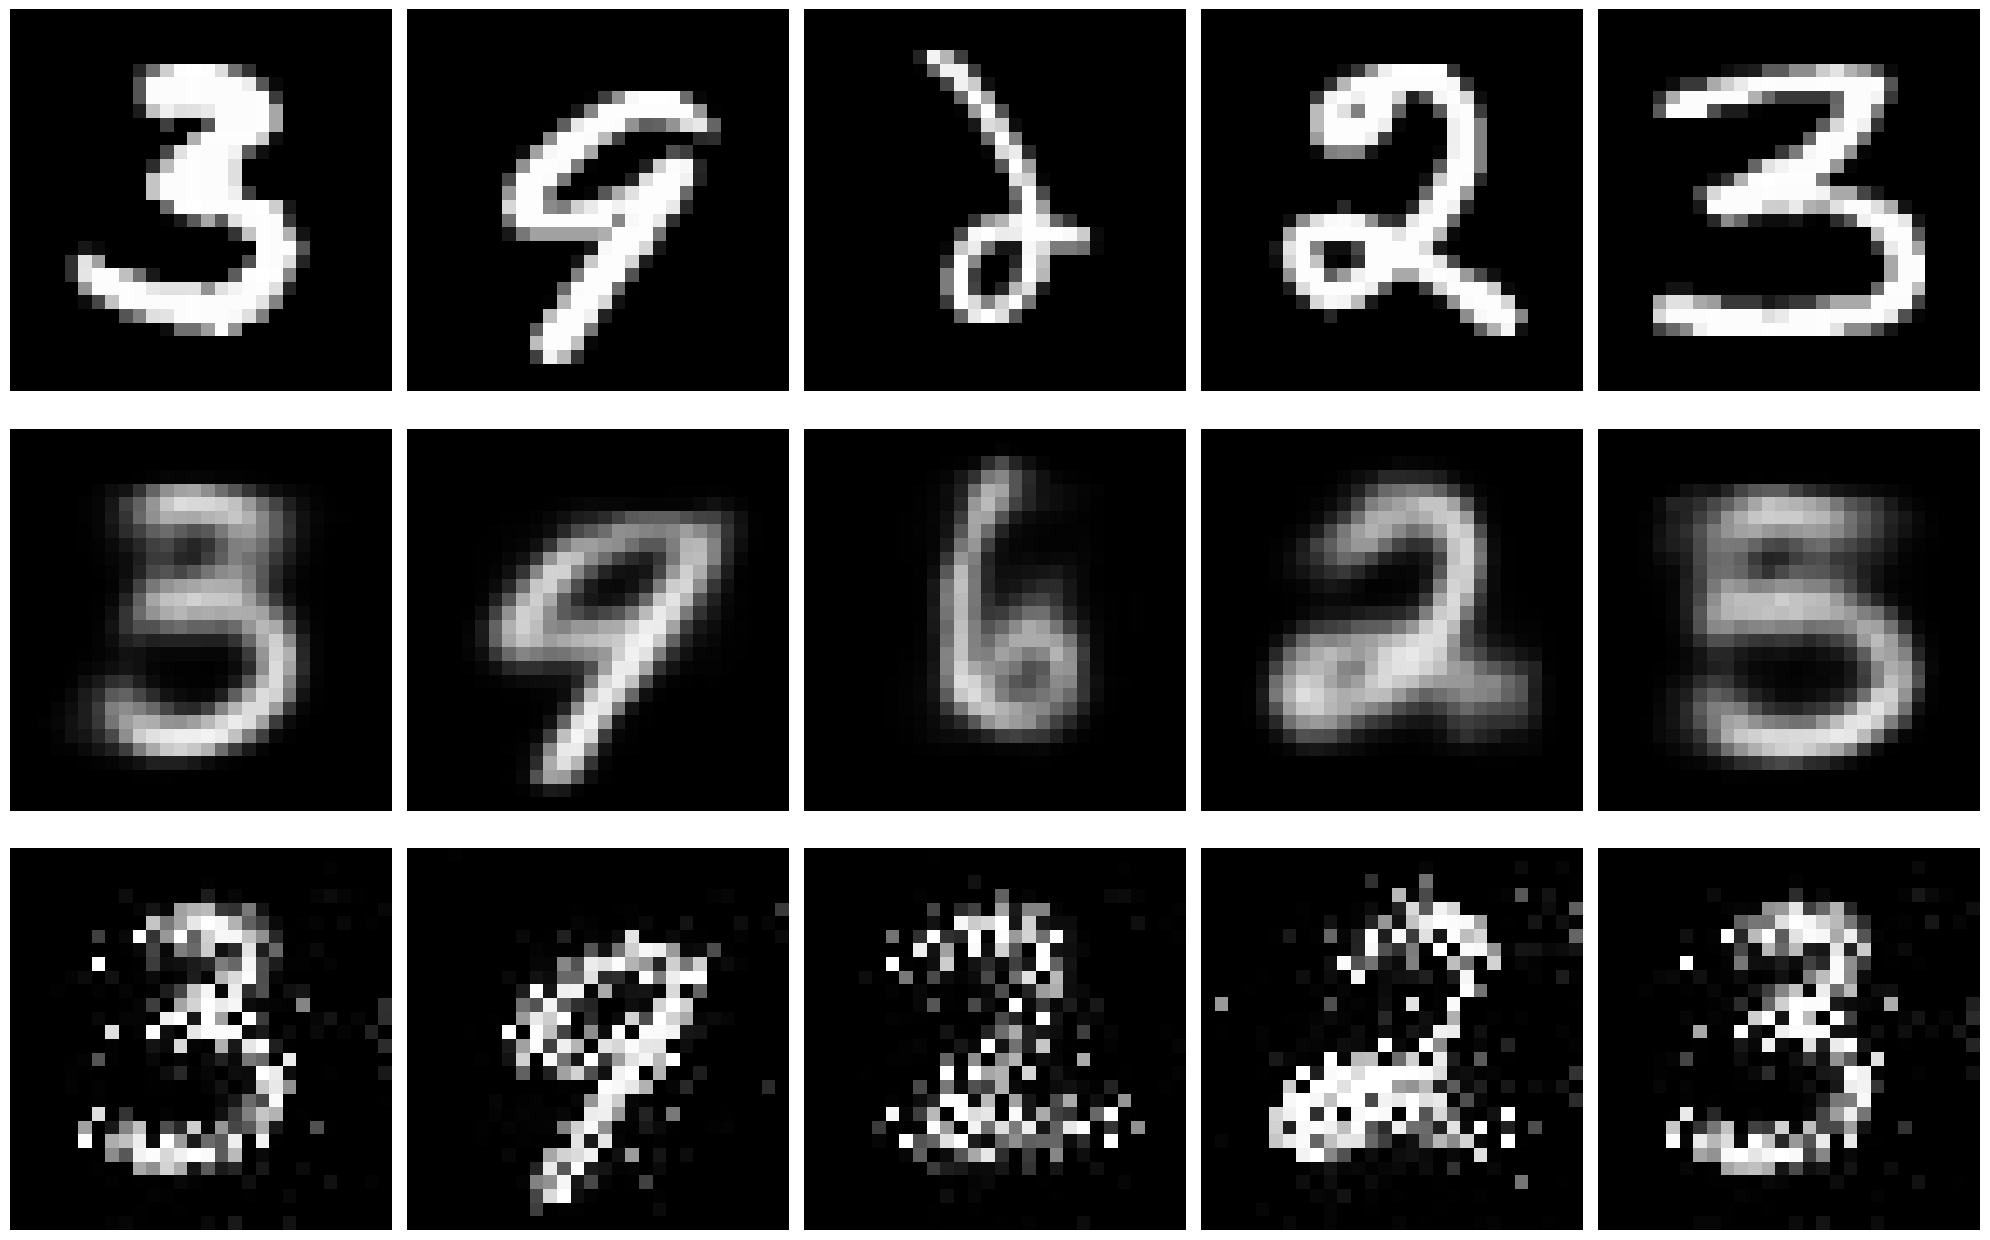

In [95]:
compare_with_vanilla(manager, 'pl +l 30')

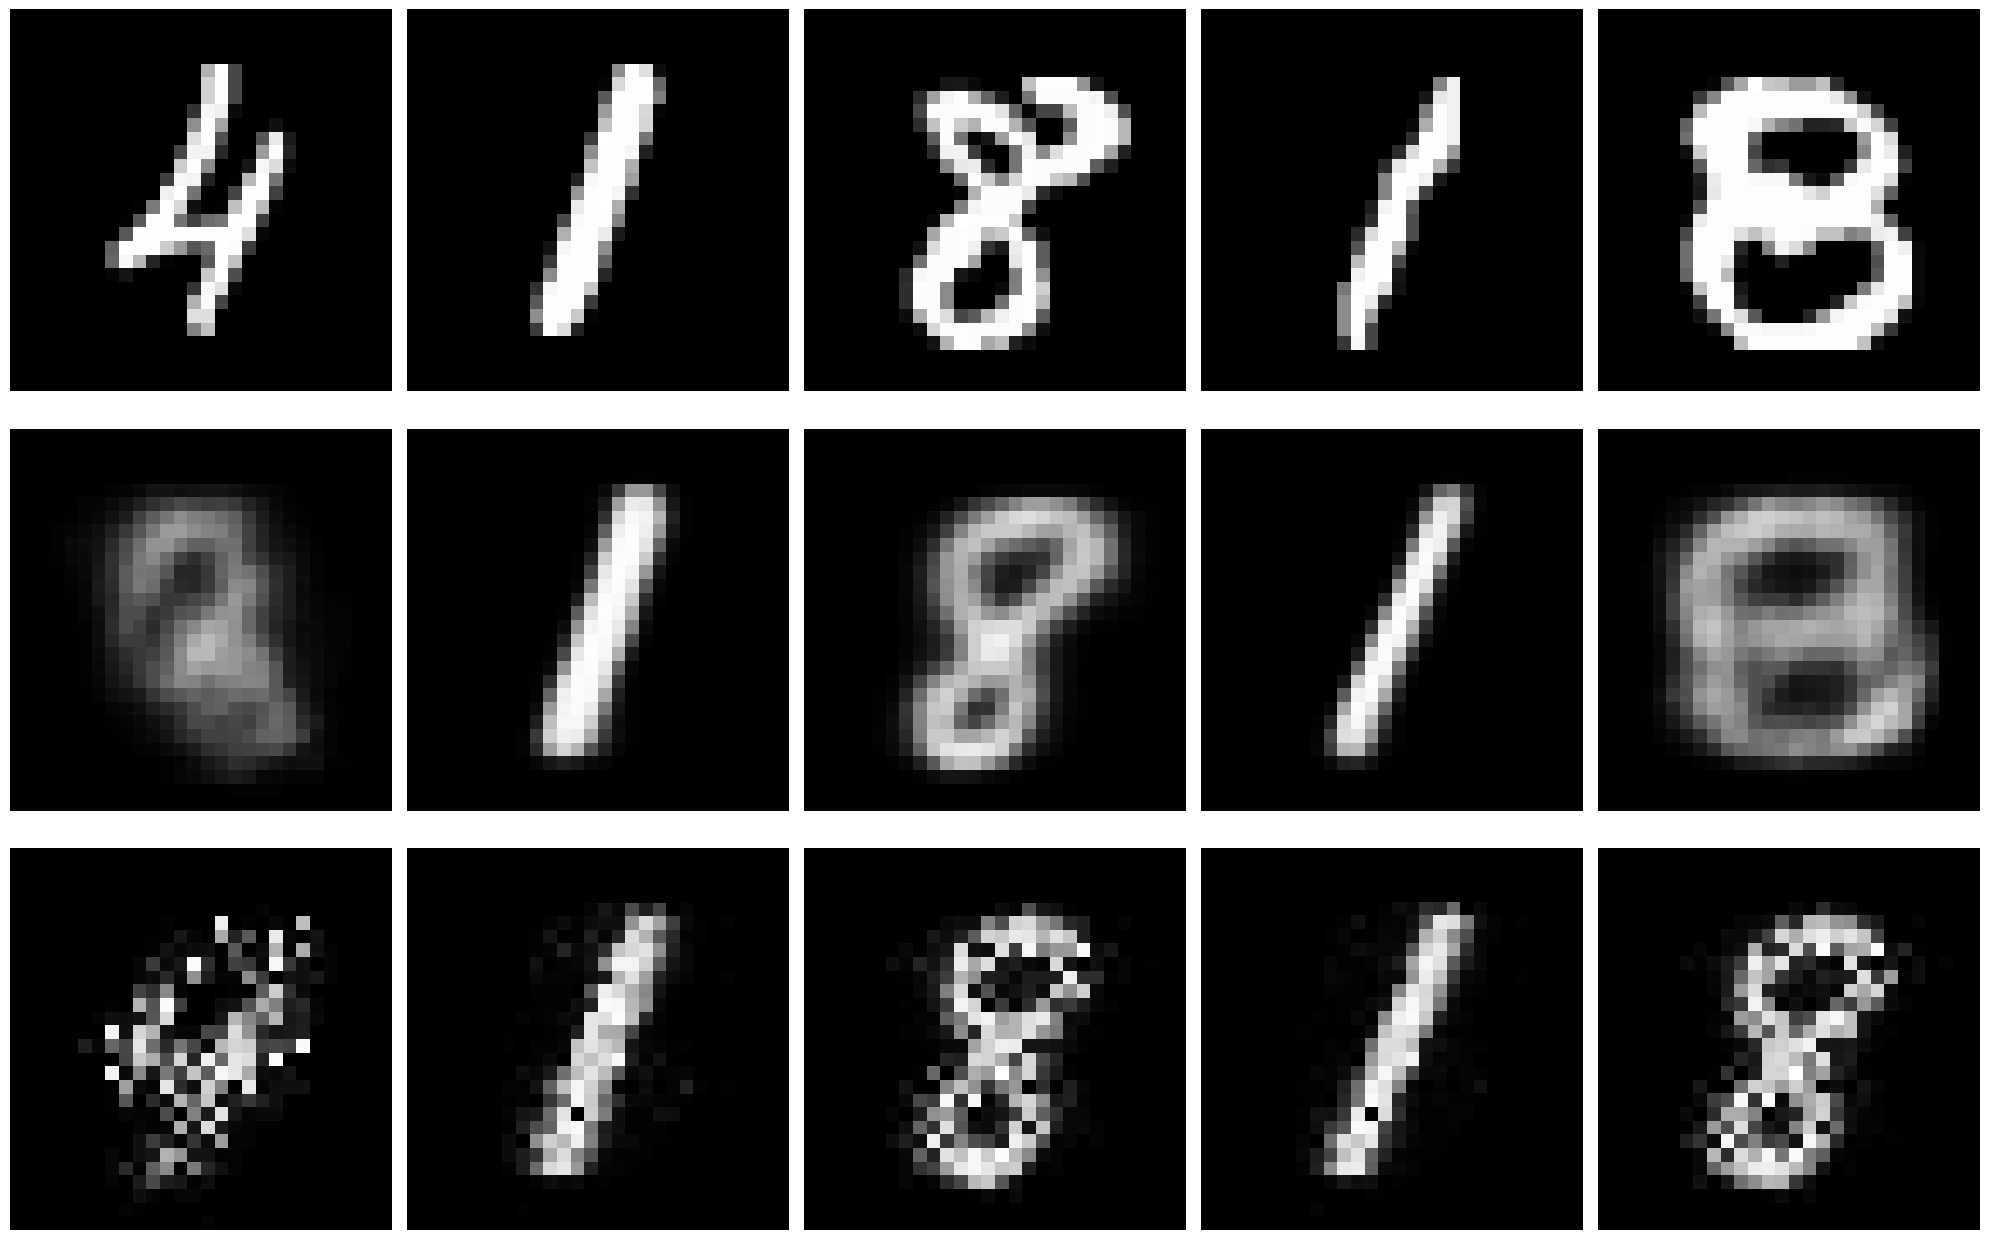

In [83]:
compare_with_vanilla(manager, 'pl 30')